In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import cv2
import math
%matplotlib inline

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    if lines is None:
        return
    img = np.copy(img)
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    print(lines)
    if lines is None:
        lines = cv2.HoughLinesP(img, rho, theta, threshold+50, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:
        lines = cv2.HoughLinesP(img, rho, theta, threshold-50, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

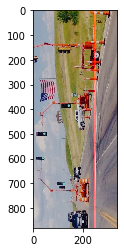

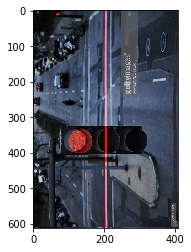

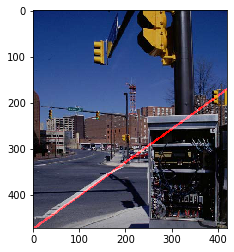

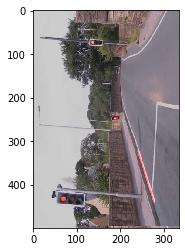

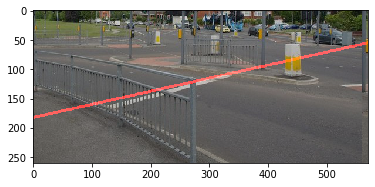

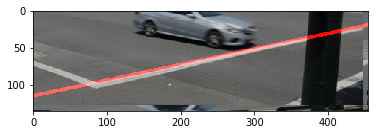

In [3]:
for i in range(1,7):
    image = mpimg.imread('Line_Data/test_images/'+str(i)+'.jpg')
    im = Image.open('Line_Data/test_images/'+str(i)+'.jpg')
    width, height = im.size
    grey_image = grayscale(image)

    canny_image = canny(grey_image,100,200)
    region_of_interest_vertices = [
        (0, height),
        (3*width/5  , height/30),
        (width, height),
    ]

    cropped_image = region_of_interest(
        canny_image,
        np.array([region_of_interest_vertices], np.int32),
    )
    
    '''
    For seeing the cropped image as the region of intrest depends on the view which we are getting
    '''
#     plt.figure()
#     plt.imshow(cropped_image)
#     plt.show()
    
    '''
    Checking for the thresholds starting from highest and then preceeding downwards
    '''
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=4,
        theta=np.pi / 60,
        threshold=300,
        lines=np.array([]),
        minLineLength=15,
        maxLineGap=5
    )
    
    if lines is None:
        lines = cv2.HoughLinesP(
            cropped_image,
            rho=4,
            theta=np.pi / 60,
            threshold=250,
            lines=np.array([]),
            minLineLength=15,
            maxLineGap=5
        )

    if lines is None:
        lines = cv2.HoughLinesP(
            cropped_image,
            rho=4,
            theta=np.pi / 60,
            threshold=200,
            lines=np.array([]),
            minLineLength=15,
            maxLineGap=5
        )


    '''
    Finding the maximum straight line which is detected 
    '''    
    ans = []
    diff = 0
    if lines is None:
        print('no line detected please contact the developer')
    else:
        for i in lines:
            i=i[0]
            temp = (i[0]-i[2])**2 + (i[1]-i[3])**2
            if diff < temp:
                diff = temp
                ans = i
        line_image = draw_lines(image, [[ans]])
        '''
        Extra ploting the line so as to cover the whole part in image
        '''
        finalans = []
        if (ans[2]- ans[0]) ==0:
            finalans=[int(ans[0]),int(0),int(ans[0]),int(height)]
        elif (ans[3]-ans[1])==0:
            finalans=[int(0),int(ans[1]),int(width),int(ans[1])]
        else:
            x1=0
            m = (ans[3]-ans[1]) / (ans[2]- ans[0])
            y1 = ans[1] + m*(x1-ans[0])
            y2=0
            x2 = ((y2-ans[1])/m) + ans[0]
            finalans=[int(x1),int(y1),int(x2),int(y2)]
        for i in finalans:
            if i<0:
                finalans = ans
                break
        line_image = draw_lines(image, [[finalans]])
        plt.figure()
        plt.imshow(line_image)
        plt.show()